# Forecasting Weather with SARIMA
## 1 . Environment

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)

# seaborn
import seaborn as sns
print('seaborn: %s' % sns.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
print('statsmodels: %s' % statsmodels.__version__)

#pymongo
import pymongo
import pprint
print('pymongo: %s' % pymongo.__version__)

#json
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import itertools
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 1.13.3
seaborn: 0.8.0
pandas: 0.20.3
sklearn: 0.19.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels: 0.8.0
pymongo: 3.4.0


## 2. Extracting Data and Transforming Data

In [2]:
# Cria conexão com o Banco de Dados
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

# Cria Instância do Banco de Dados
db = client.AgroAnalyticsDatum

In [8]:
#Obtem Id da Cidade
city_info = pd.DataFrame(list(db.cities.find({'name': "São Paulo"})))
city_info

,_id,created_at,federal_unit_id,name
0,59867b595718ddc0b8efee3b,2017-08-06 02:13:44.800,59867b535718ddc0b8efd99a,São Paulo


In [9]:
#Obtem Estações da Cidade
stations_info = pd.DataFrame(list(db.meteo_data_weather_stations.find({'city_id': ObjectId('59867b595718ddc0b8efee3b')})))
stations_info

,_id,agritempo_id,city_id,created_at,first_data_available_day,height,last_data_available_day,latitude,longitude,name,proprietary,resolved,unparsed_city
0,598f58415718dd578b4c8255,9000353,59867b595718ddc0b8efee3b,2017-08-12 19:34:25.294,1961-01-01,None,2017-08-11,None,None,São Paulo - Sao Paulo (automatica),INMET,True,São Paulo
1,598f58415718dd578b4c8256,9000661,59867b595718ddc0b8efee3b,2017-08-12 19:34:25.294,2000-01-01,None,2017-08-11,None,None,São Paulo - Sao Paulo (IAG),INMET,True,São Paulo
2,598f58415718dd578b4c8257,9000139,59867b595718ddc0b8efee3b,2017-08-12 19:34:25.294,1961-01-01,None,2017-08-11,None,None,São Paulo - SAO PAULO (MIRANTE DE SANTANA),INMET,True,São Paulo
3,598f58415718dd578b4c8258,9001827,59867b595718ddc0b8efee3b,2017-08-12 19:34:25.294,2000-03-01,None,2016-11-01,None,None,São Paulo - TRMM.815,AGRITEMPO,True,São Paulo
4,598f58415718dd578b4c8259,9001864,59867b595718ddc0b8efee3b,2017-08-12 19:34:25.294,2000-03-01,None,2016-11-01,None,None,São Paulo - TRMM.856,AGRITEMPO,True,São Paulo
5,598f58415718dd578b4c825a,9007259,59867b595718ddc0b8efee3b,2017-08-12 19:34:25.294,2000-03-01,None,2016-11-01,None,None,São Paulo - TRMM.857,AGRITEMPO,True,São Paulo


In [3]:
# Extrai dados Climáticos da Estação Selecionada
weather = list(db.meteo_data_weather_data.find({'weather_station_id': ObjectId('598f58415718dd578b4c8255')}))
weather_normalized = pd.io.json.json_normalize(weather)
df_weather = pd.DataFrame(weather_normalized[['analysis_date', 'weather_forecast.med_temp']])
df_weather = df_weather.set_index('analysis_date')
ts_weather = df_weather['2000-01-01':'2017-08-11'].groupby(pd.TimeGrouper(freq='MS')).mean()
ts_weather.head()

,weather_forecast.med_temp
analysis_date,
2000-01-01,22.806452
2000-02-01,22.586207
2000-03-01,21.774194
2000-04-01,20.833333
2000-05-01,18.032258


In [4]:
n_sample = ts_weather.shape[0]

# Cria amostra de treinamento e de teste antes de realizar a análise

n_train=int(0.94*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_weather.iloc[:n_train]['weather_forecast.med_temp']
ts_test = ts_weather.iloc[n_train:]['weather_forecast.med_temp']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(200,)
(12,)
Training Series: 
 analysis_date
2016-04-01    24.033333
2016-05-01    18.419355
2016-06-01    15.966667
2016-07-01    18.096774
2016-08-01    18.580645
Freq: MS, Name: weather_forecast.med_temp, dtype: float64 

Testing Series: 
 analysis_date
2016-09-01    19.366667
2016-10-01    21.290323
2016-11-01    21.400000
2016-12-01    23.870968
2017-01-01    23.774194
Freq: MS, Name: weather_forecast.med_temp, dtype: float64


In [5]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

### 3. Setting a Baseline with Naive Forecast

In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# walk-forward validation
history = [x for x in ts_train]
predictions = list()
for i in range(len(ts_test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = ts_test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(ts_test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=18.581, Expected= 19
>Predicted=19.367, Expected= 21
>Predicted=21.290, Expected= 21
>Predicted=21.400, Expected= 24
>Predicted=23.871, Expected= 24
>Predicted=23.774, Expected= 25
>Predicted=25.000, Expected= 23
>Predicted=22.710, Expected= 21
>Predicted=20.600, Expected= 19
>Predicted=19.226, Expected= 18
>Predicted=18.067, Expected= 17
>Predicted=16.839, Expected= 18
RMSE: 1.501


### 4. Model Identification (ARIMA Model Determination)

In [105]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

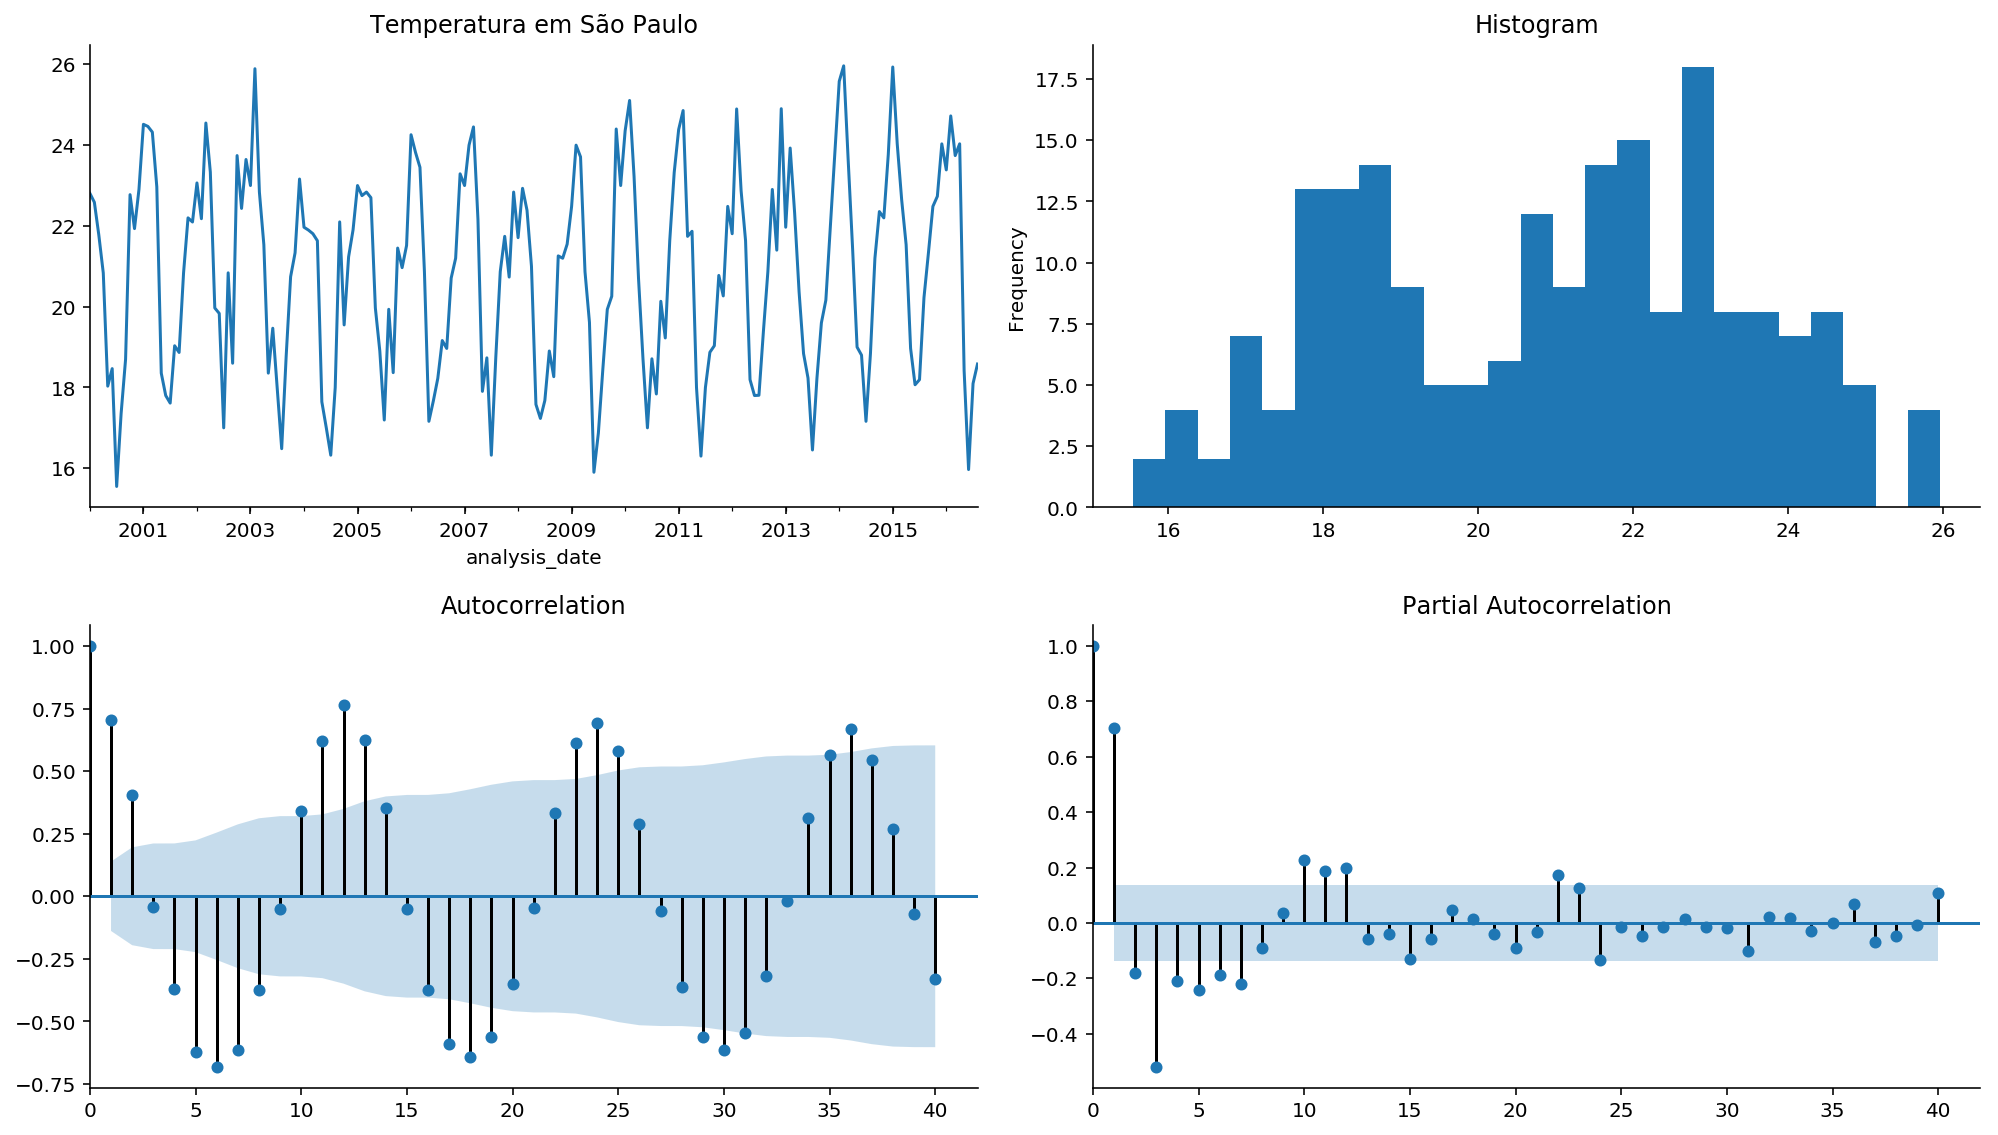

In [107]:
tsplot(ts_train, title='Temperatura em São Paulo', lags=40);

In [110]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    
    cols = ['EQM']
    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)
    
    
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                
                order = (p,d,q)
                
                # initialize to store results for this parameter set
                this_model = pd.DataFrame(index=[order], columns=cols)
                
                try:
                    mse = evaluate_arima_model(train, test, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    this_model['EQM']=mse
                    df_results = df_results.append(this_model)
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return df_results

# evaluate parameters
p_values = range(0,5)
d_values = range(0,1)
q_values = range(0,5)
warnings.filterwarnings("ignore")
df_results = evaluate_models(ts_train, ts_test, p_values, d_values, q_values)

Best ARIMA(4, 0, 1) MSE=0.794


In [111]:
df_results.sort_values(by='EQM').head(10)

,EQM
"(4, 0, 1)",0.793916
"(3, 0, 1)",0.795831
"(4, 0, 0)",1.002635
"(2, 0, 1)",1.008726
"(3, 0, 0)",1.095924
"(0, 0, 4)",1.275670
"(1, 0, 2)",1.332691
"(2, 0, 0)",1.407529
"(0, 0, 3)",1.431765
"(1, 0, 4)",1.463695


In [112]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 5
d_max = 0
q_max = 5

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.ARIMA(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
results_aic = results_aic[results_aic.columns].astype(float)

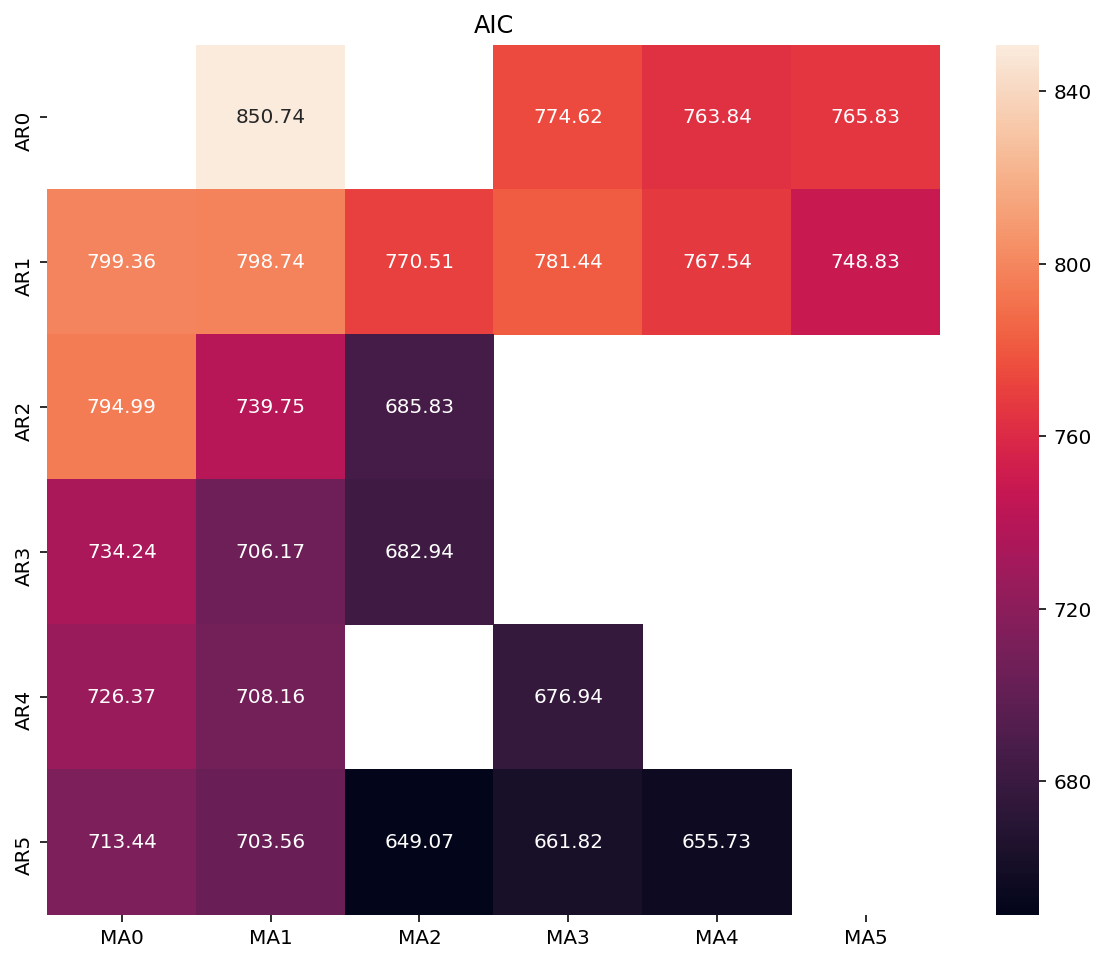

In [113]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_aic,
                 mask=results_aic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('AIC');

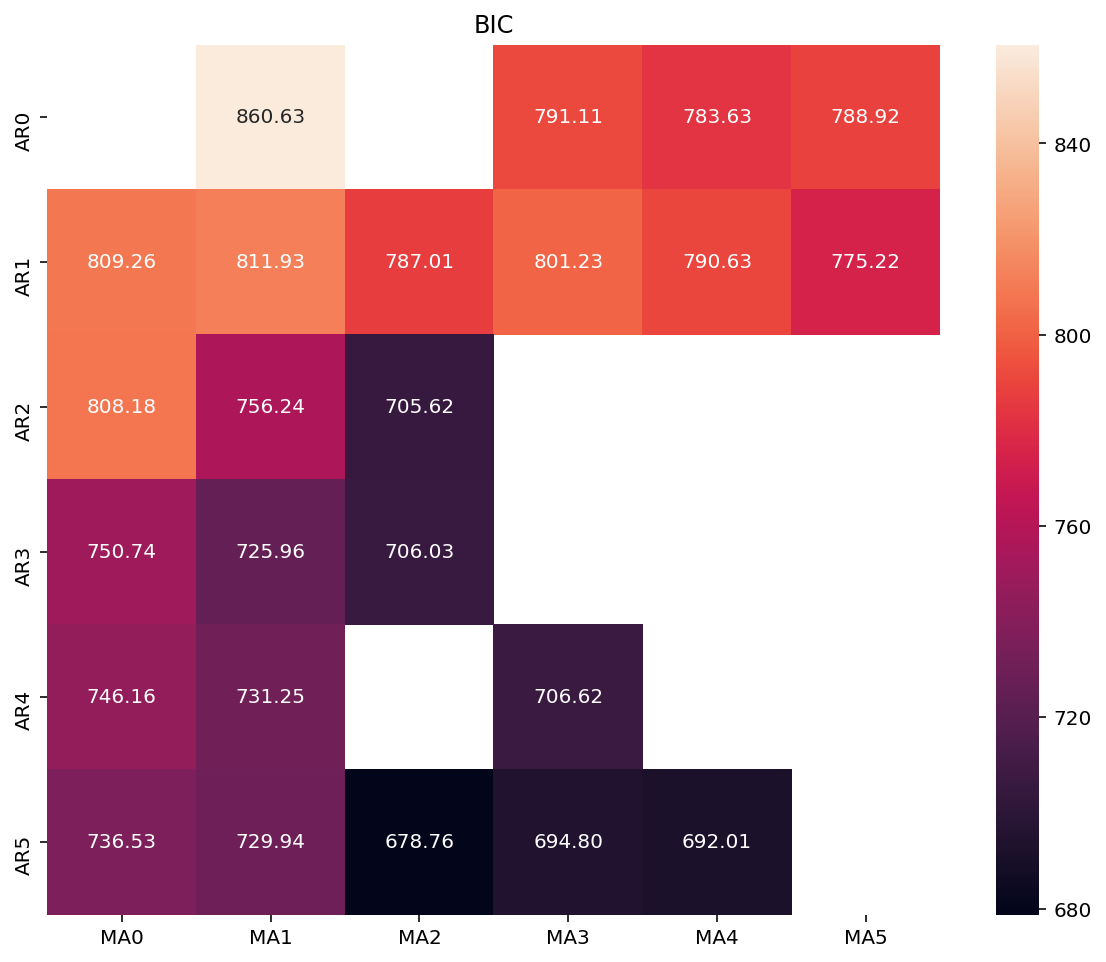

In [114]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [8]:
#Model Estimation

# Fit the model
arima401 = sm.tsa.SARIMAX(ts_train, order=(4,0,1))
model_results = arima401.fit()
model_results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Statespace Model Results                              
=====================================================================================
Dep. Variable:     weather_forecast.med_temp   No. Observations:                  200
Model:                      SARIMAX(4, 0, 1)   Log Likelihood                -369.972
Date:                       Tue, 21 Nov 2017   AIC                            751.944
Time:                               01:46:13   BIC                            771.734
Sample:                           01-01-2000   HQIC                           759.953
                                - 08-01-2016                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7907      0.065     27.584      0.000       1.664       1.918
ar.L2         -0.5802      0.134     -4.316      0.000      -0.844      -0.317
ar.L3         -0.7277      0.135     -5.389      0.000      -0.992      -0.463
ar.L4          0.5172      0.065      7.970      0.000       0.390       0.644
ma.L1         -0.9874      0.043    -22.946      0.000      -1.072      -0.903
sigma2         2.3029      0.267      8.641      0.000       1.781       2.825
===================================================================================
Ljung-Box (Q):                      100.87   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               0.76   Skew:                            -0.03
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 5. Model Diagnostic Checking

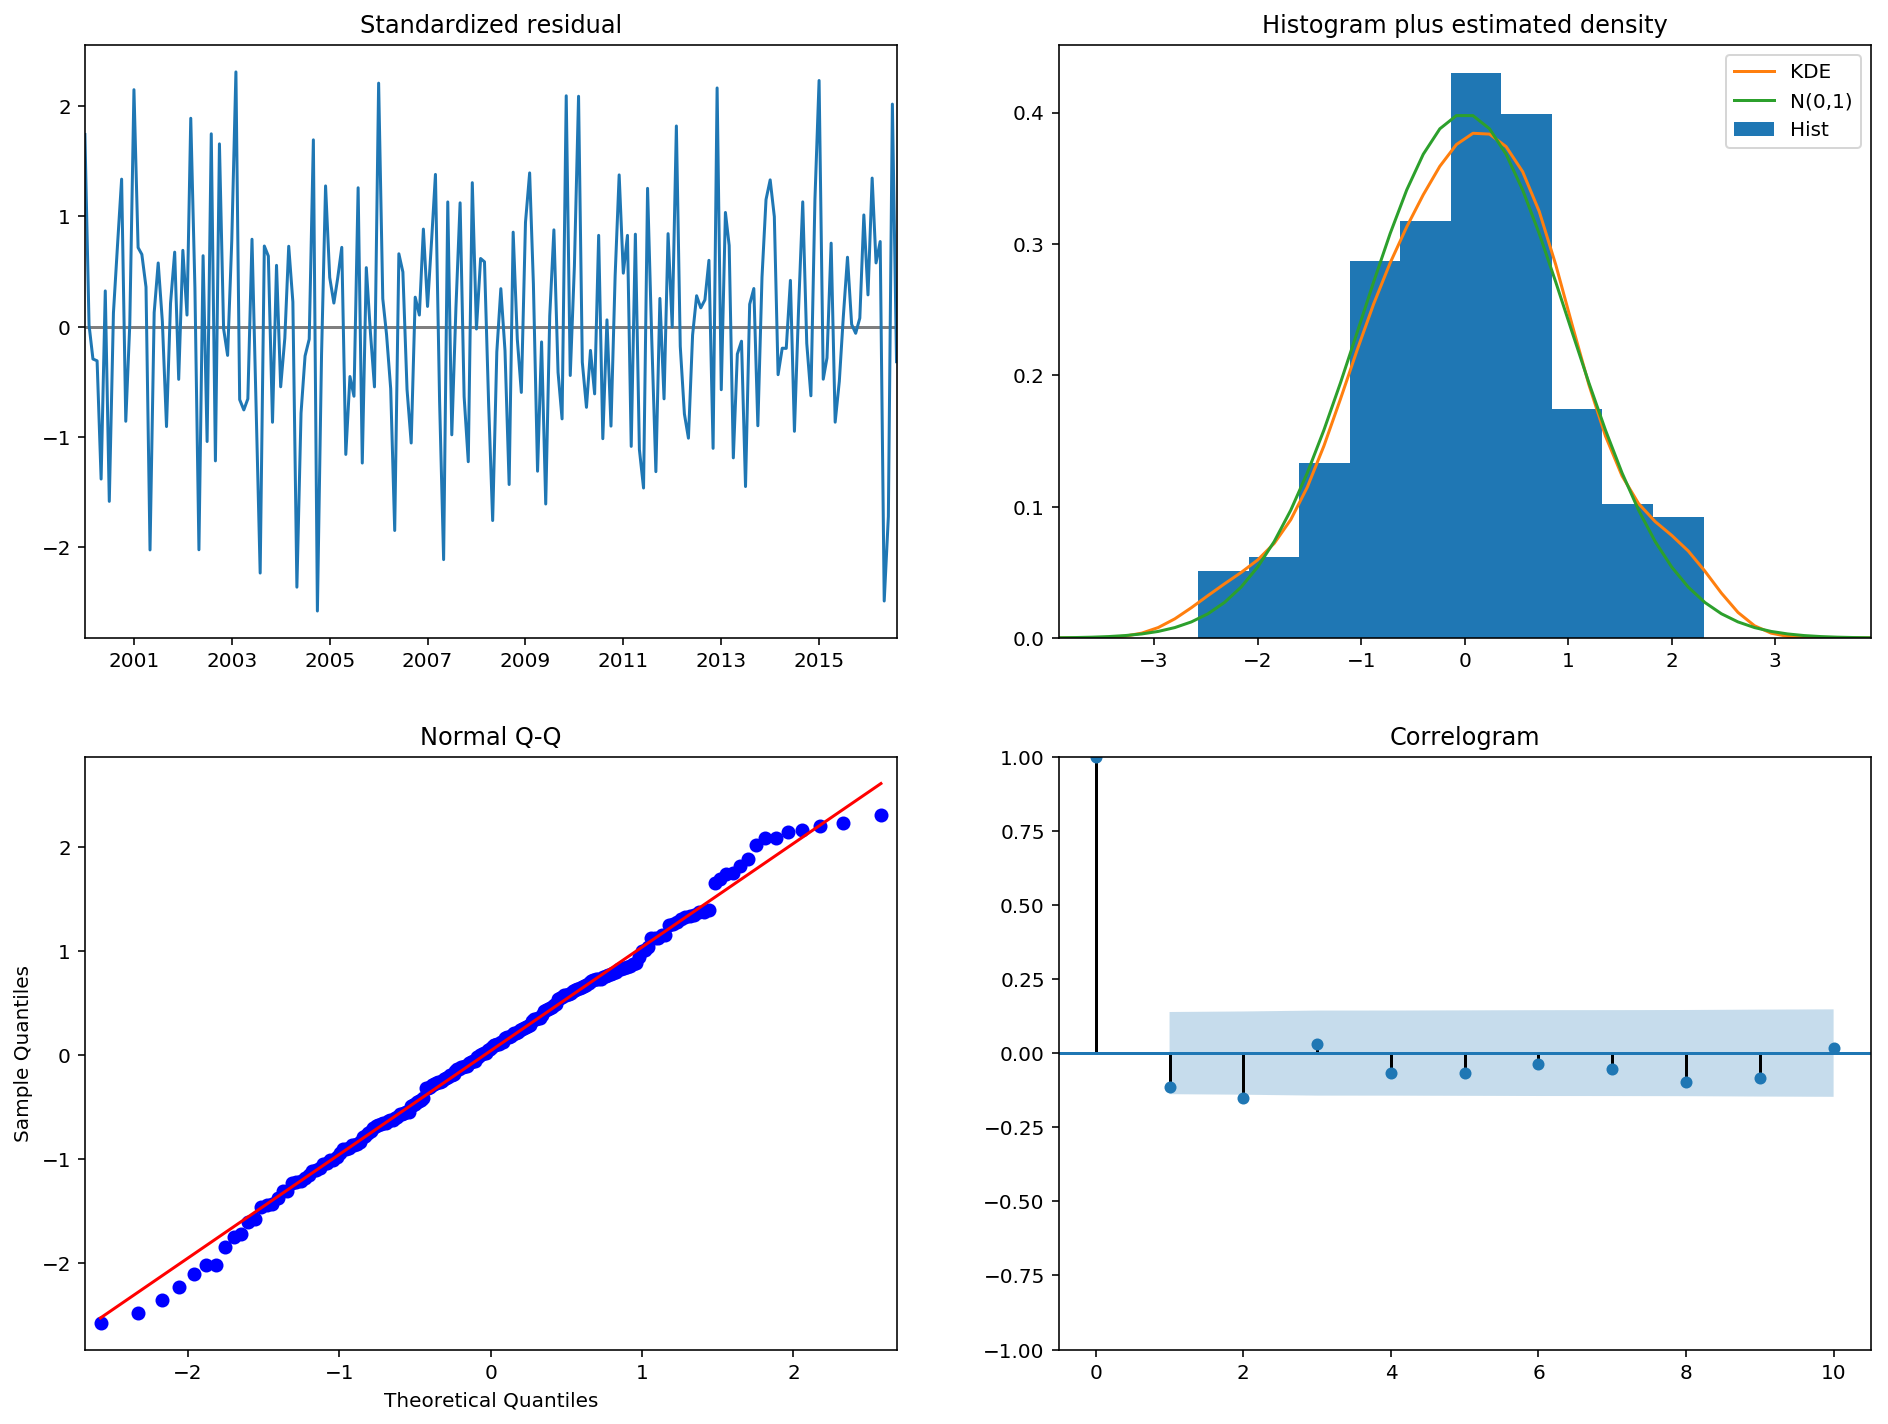

In [117]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

model_results.plot_diagnostics(figsize=(16, 12));

In [118]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

Test heteroskedasticity of residuals (breakvar): stat=0.806, p=0.378

Test normality of residuals (jarquebera): stat=0.340, p=0.844

Test serial correlation of residuals (ljungbox): stat=119.873, p=0.000

Durbin-Watson test on residuals: d=2.21
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


### 6. Model performance evaluation (in-sample fit)

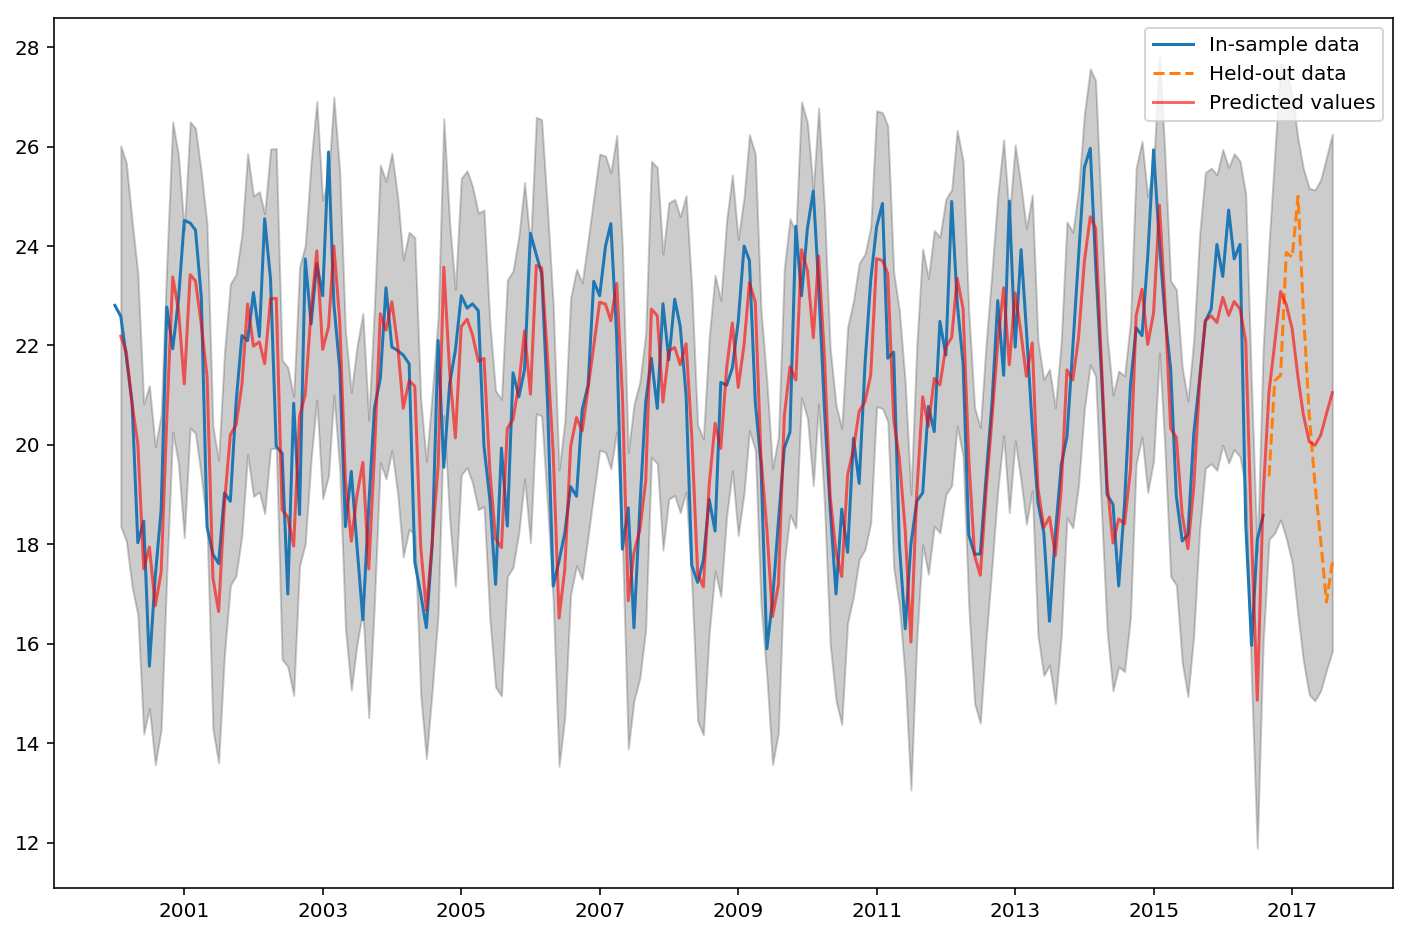

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('2000-02-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

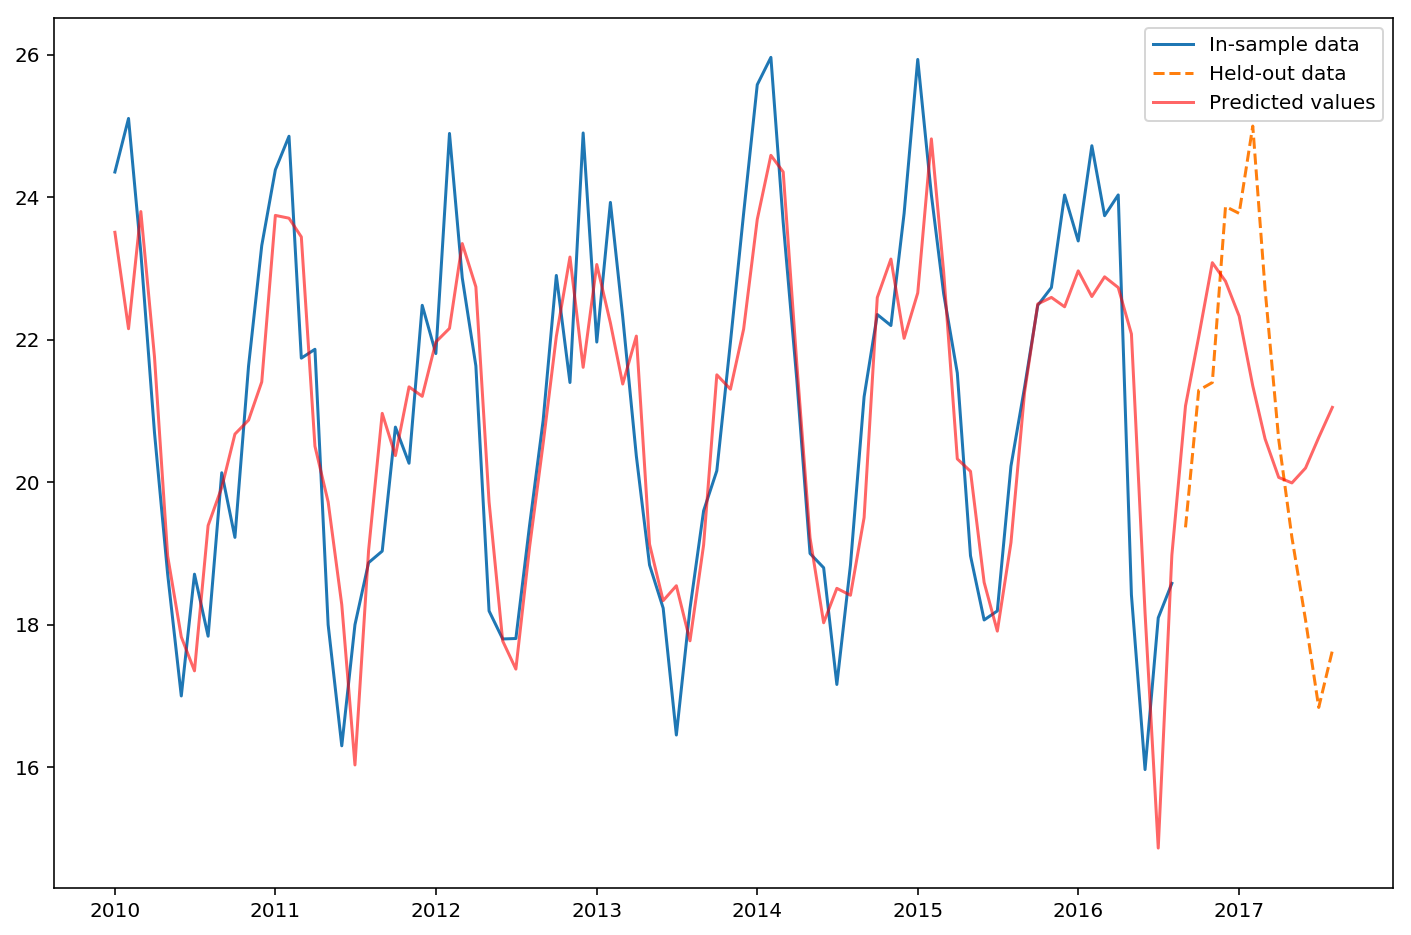

In [20]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train['2010-01-01':], label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test['2010-01-01':], label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('2000-02-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean['2010-01-01':], 'r', alpha=.6, label='Predicted values')
#ax1.fill_between(pred_ci['2010-01-01':].index,
                 #pred_ci['2010-01-01':].iloc[:, 0],
                 #pred_ci['2010-01-01':].iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [15]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [18]:
# Training Set

rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

RMSE:  1.4974038891
MAPE:  5.836652725317922


In [19]:
# Test Set

rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print("RMSE: ", rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print("MAPE: ", mape)

RMSE:  2.21055172964
MAPE:  9.56069772996944


In [17]:
mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
print("MASE: ", mase)


mase = get_mase(ts_test, pred_mean.ix[ts_test.index])
print("MASE: ", mase)

MASE:  1.0000000000000009
MASE:  0.9900188886312291
